In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import yaml
from utils_visual import *

In [ ]:
# define global variables for file managment
file_path = 'exps.xlsx'
sheet_name = 'pw-graph-clusters'

In [2]:
old_best_model = 0.211
params = .5, .4, .1

In [ ]:
sum(params)

## Intoducing Pruned GSBW-per (PGSBW) and conceptualized GSBW-per (CGSBW)

### Performance based on the size of spectral clustering

In [ ]:
data = pd.read_excel('exps.xlsx', sheet_name=sheet_name)
data

### Prepare data for ploting and analysis to gain insight

In [ ]:
clusters_experiment = data.iloc[:, :-2]
clusters_experiment

In [ ]:
cls_avg = data["avg_pre"].dropna().values
cls_avg

In [ ]:
cls_prune_per = data["%prune"].dropna().values
cls_prune_per

In [ ]:
subset_size = 8
windows = [10, 30, 50, 70]
evaluated_models = {}

for i in range(0, clusters_experiment.shape[1], subset_size):
    subset_exp = clusters_experiment.iloc[:, i:i+subset_size]
    subset_avgs = cls_avg[i:i+subset_size]
    subset_prunes = cls_prune_per[i:i+subset_size]
    plot_experiment(subset_exp, subset_avgs, subset_prunes, old_best_model, title=f'{windows[i//subset_size]}% Window')
    
    cm = compare_models(subset_exp)
    plot_heatmap(cm) 
    
    em = evaluate_models(cm, subset_avgs, subset_prunes, *params)
    evaluated_models.update(em)

In [ ]:
for i in range(0, 4*8, 8):
    print(max(cls_avg[i:i+8]))

In [ ]:
print(evaluated_models)

### Performance based on the size of spectral clustering and similarity between nodes

In [ ]:
data = pd.read_excel('exps.xlsx', sheet_name=f"{sheet_name}-sim")
data

### Prepare data for ploting and analysis to gain insight

In [ ]:
cls_sim_experiment = data.iloc[:, :-2]
cls_sim_experiment

In [ ]:
data['avg_pre'].dropna().values

In [ ]:
submodel_size = 16
model_categ = []
model_categ_avgs = []
model_categ_prune = []

for i in range(0, cls_sim_experiment.shape[1], submodel_size):
    model_categ.append(cls_sim_experiment.iloc[:, i:i+submodel_size])
    model_categ_avgs.append(data['avg_pre'][i:i+submodel_size])
    model_categ_prune.append(data['%prune'][i:i+submodel_size])
model_categ[0]

In [ ]:
ws = [10, 30, 50, 70]
sims = [50, 70]

for i, (mc, mavg, mprune) in enumerate(zip(model_categ, model_categ_avgs, model_categ_prune)):
    for j in [0, 2]:
        # Create indices to split per similarity
        indices = [i for i in range(j, mc.shape[1], 4)] + [i+1 for i in range(j, mc.shape[1], 4)]
        indices.sort()

        plot_experiment(mc.iloc[:, indices], mavg.iloc[indices], mprune.iloc[indices], old_best_model,
                        title=f"{ws[i]}% Window - {sims[j//2]}% Similarity")
    
        cm = compare_models(mc.iloc[:, indices])
        plot_heatmap(cm) 

        em = evaluate_models(cm, mavg.iloc[indices].values, mprune.iloc[indices].values, *params)
        evaluated_models.update(em)

In [ ]:
# data['avg_pre'].dropna().values
for i in range(0, 4*8, 4):
    print(max(data['avg_pre'].dropna().values[i:i+8]))

In [ ]:
print(evaluated_models)

### Performance based on the size of spectral clustering and edge (wout_avg * coeff) between nodes

In [ ]:
data = pd.read_excel('exps.xlsx', sheet_name=f"{sheet_name}-avg")
data.head()

In [ ]:
### Prepare data for ploting and analysis to gain insight
cls_avg_experiment = data.iloc[:, :-2]

model_categ = []
model_categ_avgs = []
model_categ_prune = []

for i in range(0, cls_avg_experiment.shape[1], submodel_size):
    model_categ.append(cls_avg_experiment.iloc[:, i:i+submodel_size])
    model_categ_avgs.append(data['avg_pre'][i:i+submodel_size])
    model_categ_prune.append(data['%prune'][i:i+submodel_size])

In [ ]:
model_categ[0].head()

In [ ]:
ws = [10, 30, 50, 70]
coeffs = [1.3, 1.4]

for i, (mc, mavg, mprune) in enumerate(zip(model_categ, model_categ_avgs, model_categ_prune)):
    for j in [0, 2]:
        # Create indices to split per similarity
        indices = [i for i in range(j, mc.shape[1], 4)] + [i+1 for i in range(j, mc.shape[1], 4)]
        indices.sort()

        plot_experiment(mc.iloc[:, indices], mavg.iloc[indices].values, mprune.iloc[indices].values, old_best_model,
                        title=f"{ws[i]}% Window - {coeffs[j//2]} * avg_wout")
    
        cm = compare_models(mc.iloc[:, indices])
        plot_heatmap(cm) 
        
        em = evaluate_models(cm, mavg.iloc[indices].values, mprune.iloc[indices].values, *params)
        evaluated_models.update(em)

In [ ]:
mavg

In [ ]:
# data['avg_pre'].dropna().values
for i in range(0, 4*8, 4):
    print(max(data['avg_pre'].values[i:i+8]))

In [ ]:
print(evaluated_models)
print(len(evaluated_models))

In [ ]:
sorted_evaluated_models = sorted(evaluated_models.items(), key=lambda x: x[1], reverse=True)

In [ ]:
models_eval = pd.DataFrame(sorted_evaluated_models, columns=['model', 'value'])
models_eval.head()

In [ ]:
models_eval.plot()
plt.xlabel("Model")
plt.ylabel("Model Evaluation")
plt.title("PGSB-CGSB Models")
plt.show()

In [ ]:
# Define regular expression pattern
pattern = r'-(\d+\.\d+)$'

# Extract the matching pattern from the 'cgsb_model' column
models_eval['group'] = models_eval['model'].str.extract(pattern, expand=False)
models_eval['group'].fillna('cls', inplace=True)
models_eval

In [ ]:
top_n = 3
# Group the DataFrame by the extracted 'group' column
grouped_df = models_eval.groupby(by='group')

best_n_per_exp = {}
# Iterate over the groups and print the group name along with the corresponding data
for group, data in grouped_df:
    # pick each row and convert to dictionary
    for index, row in data.iloc[:top_n, :2].iterrows():
        best_n_per_exp.update({row["model"]: row["value"]})
    
print(best_n_per_exp)
print(len(best_n_per_exp))

In [ ]:
best_nm_per_exp = pd.DataFrame(best_n_per_exp.items(), columns=["model", "value"])
best_nm_per_exp = best_nm_per_exp.sort_values(by='value', ascending=False).reset_index(drop=True)
best_nm_per_exp

In [ ]:
# Plot the DataFrame with all labels displayed
fig, ax = plt.subplots(figsize=(9, 6))

# Set the tick positions and labels
ax.set_xticks(range(len(best_nm_per_exp['model'])))
ax.set_xticklabels(best_nm_per_exp['model'], rotation=70)

# Plot the data
ax.plot(best_nm_per_exp['value'])

plt.tight_layout()
plt.ylabel("Model Evaluation")
plt.title(f"Top {top_n} Models Per Experiment")
plt.show()

In [3]:
best_so_far = pd.read_excel('topn_models.xlsx')
best_so_far.head()

,PGSBW-0.5-110-0.5,PGSBW-0.3-130-0.5,PGSBW-0.3-110-0.5,PGSBW-0.1-170-0.7,CGSBW-0.1-170-1.4,PGSBW-0.1-130-0.7,PGSBW-0.1-150-0.7,PGSBW-0.7-170-1.4,PGSBW-0.7-130-1.3,PGSBW-0.3-170-1.4,...,CGSB-50-1.2,CGSB-150-0.1,CGSB-110-0.1,CGSB-170-0.3,CGSB-30-0.3,CGSB-110,CGSB-170,CGSB-30,avg,%prune
0,0.298,0.309,0.310,0.286,0.231,0.282,0.263,0.340,0.338,0.335,...,0.294,0.299,0.299,0.299,0.299,0.299,0.299,0.294,0.24460,95.312151
1,0.181,0.053,0.052,0.124,0.018,0.159,0.101,0.037,0.038,0.084,...,0.068,0.069,0.069,0.059,0.059,0.069,0.069,0.076,0.24437,92.133429
2,0.238,0.201,0.192,0.179,0.125,0.179,0.167,0.184,0.184,0.183,...,0.176,0.178,0.177,0.177,0.174,0.177,0.177,0.175,0.24379,96.078864
3,0.114,0.102,0.104,0.146,0.133,0.232,0.148,0.107,0.108,0.108,...,0.128,0.129,0.128,0.129,0.130,0.129,0.129,0.128,0.24402,92.142894
4,0.306,0.302,0.309,0.308,0.234,0.317,0.317,0.291,0.305,0.321,...,0.309,0.313,0.310,0.314,0.313,0.314,0.314,0.311,0.24365,92.827565


In [4]:
avgs, prunes = best_so_far[['avg', '%prune']].dropna().T.values.astype(float)
best_so_far = best_so_far.drop(columns=['avg', '%prune'])
best_so_far.head()

,PGSBW-0.5-110-0.5,PGSBW-0.3-130-0.5,PGSBW-0.3-110-0.5,PGSBW-0.1-170-0.7,CGSBW-0.1-170-1.4,PGSBW-0.1-130-0.7,PGSBW-0.1-150-0.7,PGSBW-0.7-170-1.4,PGSBW-0.7-130-1.3,PGSBW-0.3-170-1.4,...,CGSB-110-1.1,CGSB-170-0.1,CGSB-50-1.2,CGSB-150-0.1,CGSB-110-0.1,CGSB-170-0.3,CGSB-30-0.3,CGSB-110,CGSB-170,CGSB-30
0,0.298,0.309,0.310,0.286,0.231,0.282,0.263,0.340,0.338,0.335,...,0.299,0.284,0.294,0.299,0.299,0.299,0.299,0.299,0.299,0.294
1,0.181,0.053,0.052,0.124,0.018,0.159,0.101,0.037,0.038,0.084,...,0.069,0.071,0.068,0.069,0.069,0.059,0.059,0.069,0.069,0.076
2,0.238,0.201,0.192,0.179,0.125,0.179,0.167,0.184,0.184,0.183,...,0.177,0.181,0.176,0.178,0.177,0.177,0.174,0.177,0.177,0.175
3,0.114,0.102,0.104,0.146,0.133,0.232,0.148,0.107,0.108,0.108,...,0.129,0.129,0.128,0.129,0.128,0.129,0.130,0.129,0.129,0.128
4,0.306,0.302,0.309,0.308,0.234,0.317,0.317,0.291,0.305,0.321,...,0.314,0.311,0.309,0.313,0.310,0.314,0.313,0.314,0.314,0.311


In [ ]:
best_to_compare = pd.DataFrame()
best_avgs = []
best_prunes = []

In [ ]:
all_sheets = pd.read_excel('exps.xlsx', sheet_name=None)

In [ ]:
for bm in best_nm_per_exp['model']:
    for sheet_name, sheet in all_sheets.items():
        try:
            wanted = sheet[bm]
            idx = list(sheet.columns).index(bm)
            avg, prune = sheet['avg_pre'].iloc[idx], sheet['%prune'].iloc[idx]
            best_avgs.append(avg)
            best_prunes.append(prune)
            best_to_compare[bm] = wanted.values
        except KeyError:
            continue

In [ ]:
best_to_compare2 = pd.concat([best_to_compare, best_so_far], axis=1)

In [ ]:
new_avgs = list(avgs[:2*27]) + best_avgs
new_prunes = list(prunes[:2*27]) + best_prunes

In [ ]:
for _ in range(100-(2*27)-15):
    new_avgs.append(pd.NA)
    new_prunes.append(pd.NA)

In [ ]:
best_to_compare2['avg'] = new_avgs
best_to_compare2['%prune'] = new_prunes

In [ ]:
best_to_compare2

In [ ]:
best_to_compare2.to_excel('topn_models.xlsx', index=False)

In [ ]:
avgs, prunes = best_to_compare2[['avg', '%prune']].dropna().T.to_numpy().astype(float)

In [ ]:
best_to_compare = best_to_compare2.drop(columns=['avg', '%prune'])

In [5]:
evaluated_models = {}

In [6]:
cm = compare_models(best_so_far) # compare only cgsb's

em = evaluate_models(cm, avgs, prunes, *params)
evaluated_models.update(em)

In [7]:
print(len(evaluated_models))
print(evaluated_models)

69
{'PGSBW-0.5-110-0.5': 0.4112, 'PGSBW-0.3-130-0.5': 0.4219, 'PGSBW-0.3-110-0.5': 0.4108, 'PGSBW-0.1-170-0.7': 0.4325, 'CGSBW-0.1-170-1.4': 0.4048, 'PGSBW-0.1-130-0.7': 0.4373, 'PGSBW-0.1-150-0.7': 0.4242, 'PGSBW-0.7-170-1.4': 0.4001, 'PGSBW-0.7-130-1.3': 0.408, 'PGSBW-0.3-170-1.4': 0.4103, 'PGSBW-0.7-110-1.3': 0.3963, 'PGSBW-0.5-110-1.3': 0.4043, 'CGSBW-0.5-170': 0.4219, 'CGSBW-0.3-130': 0.4042, 'CGSBW-0.3-150': 0.4168, 'PGSBW-170-0.5': 0.4267, 'CGSBW-170-1.3': 0.4028, 'PGSBW-30-0.7': 0.4286, 'PGSBW-130-0.7': 0.3979, 'PGSBW-150-0.7': 0.4177, 'CGSBW-170-1.2': 0.3796, 'PGSBW-110-0.5': 0.3968, 'PGSBW-150-0.5': 0.406, 'PGSBW-170-0.3': 0.392, 'PGSBW-150-1.4': 0.3388, 'PGSBW-170-1.2': 0.34, 'CGSBW-30-1.4': 0.3155, 'PGSBW-170-1.4': 0.3827, 'CGSBW-30-1.3': 0.3783, 'CGSBW-30-1.2': 0.3695, 'PGSBW-150-0.3': 0.4064, 'CGSBW-50-1.3': 0.374, 'PGSBW-170': 0.3915, 'PGSBW-50-0.3': 0.3848, 'CGSBW-30-1.1': 0.3405, 'PGSBW-130': 0.3457, 'PGSBW-150-0.1': 0.3968, 'PGSBW-170-0.1': 0.3884, 'PGSBW-90-0.1': 0.3

In [8]:
sorted_evaluated_models = sorted(evaluated_models.items(), key=lambda x: x[1], reverse=True)
models_eval = pd.DataFrame(sorted_evaluated_models, columns=['model', 'value'])
models_eval

,model,value
0,CGSB-170-0.1,0.4523
1,CGSB-30-0.3,0.4409
2,CGSB-90-1.2,0.4393
3,CGSB-50-1.2,0.4389
4,CGSB-150-0.1,0.4379
...,...,...
64,CGSBW-30-1.1,0.3405
65,PGSBW-170-1.2,0.3400
66,PGSBW-150-1.4,0.3388
67,CGSBW-50-1.1,0.3375


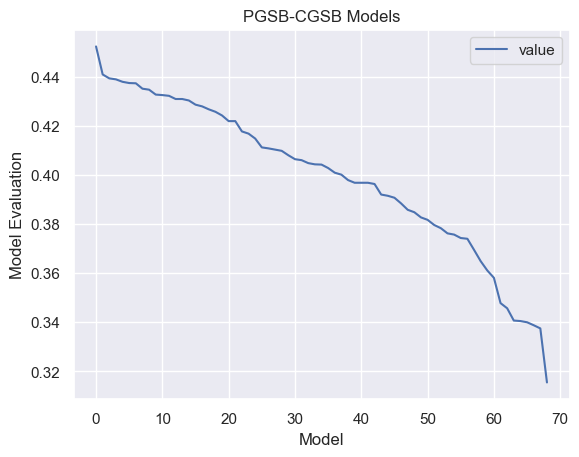

In [9]:
models_eval.plot()
plt.xlabel("Model")
plt.ylabel("Model Evaluation")
plt.title("PGSB-CGSB Models")
plt.show()

In [10]:
top_n = 10
best_nm_per_exp = models_eval.iloc[:10, :]

In [13]:
mean_precisions = top10_models.mean().values
mean_precisions

array([0.24323, 0.24302, 0.24324, 0.2434 , 0.24425, 0.24437, 0.24035,
       0.24409, 0.24399, 0.24365])

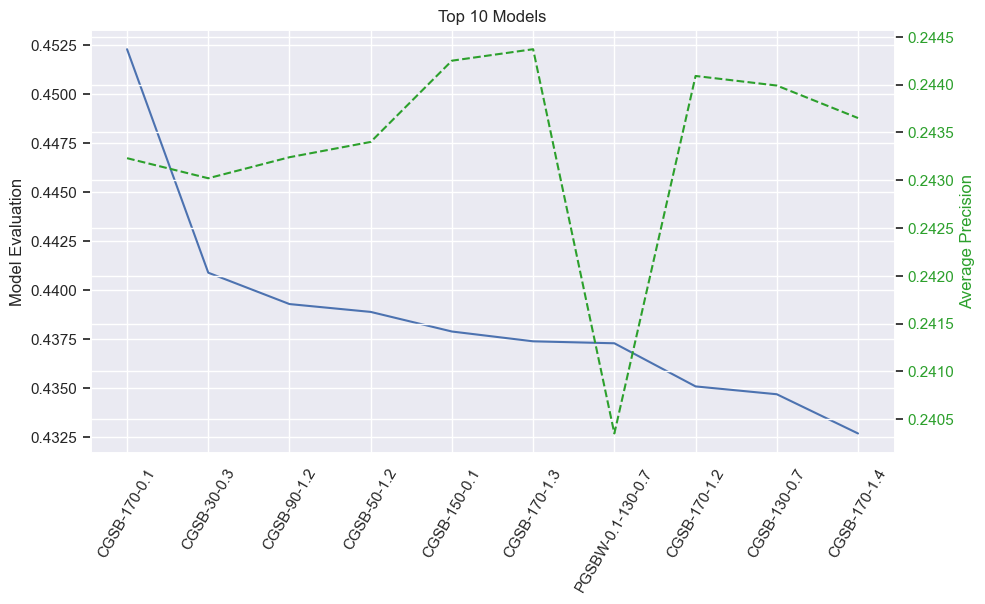

In [14]:
# Plot the DataFrame with all labels displayed
fig, ax = plt.subplots(figsize=(9, 6))

# Set the tick positions and labels
ax.set_xticks(range(len(best_nm_per_exp['model'])))
ax.set_xticklabels(best_nm_per_exp['model'], rotation=60)

# Plot the data
ax.plot(best_nm_per_exp['value'])
plt.tight_layout()
plt.ylabel("Model Evaluation")
plt.title(f"Top {top_n} Models")

ax2 = ax.twinx()  # instantiate a second y-axis that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Average Precision', color=color)
ax2.plot(top10_models.columns, mean_precisions, label='Average Precision', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [ ]:
best_so_far

In [12]:
top10_models = best_so_far[best_nm_per_exp['model'].values]

### Difference Plot

### Area plot

<Axes: >

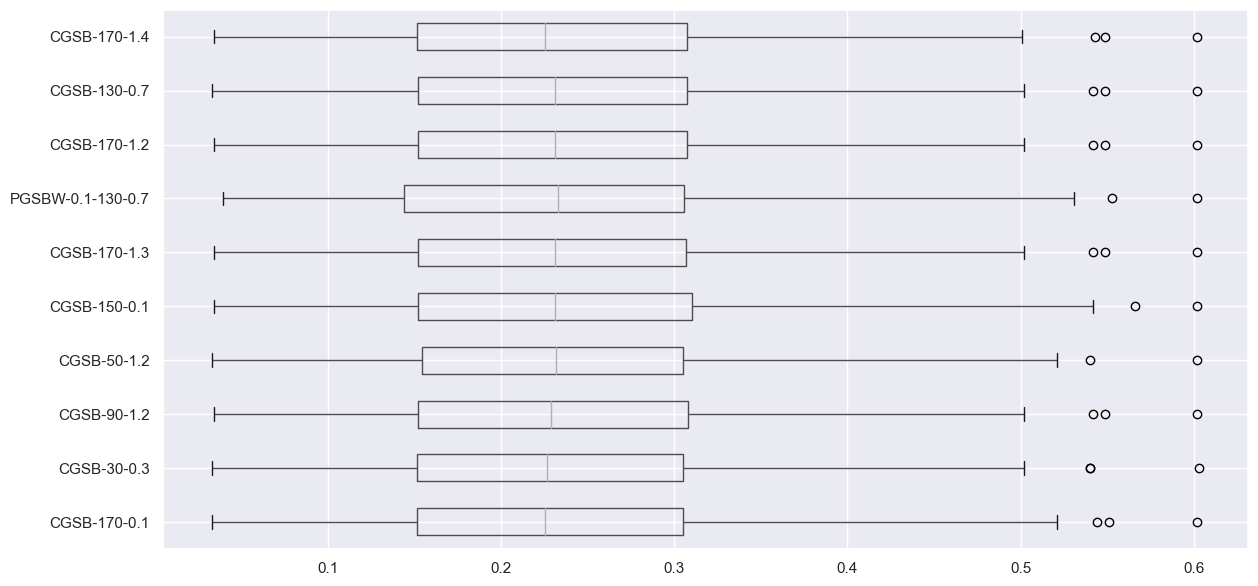

In [15]:
top10_models.boxplot(figsize=(14,7), vert=False)

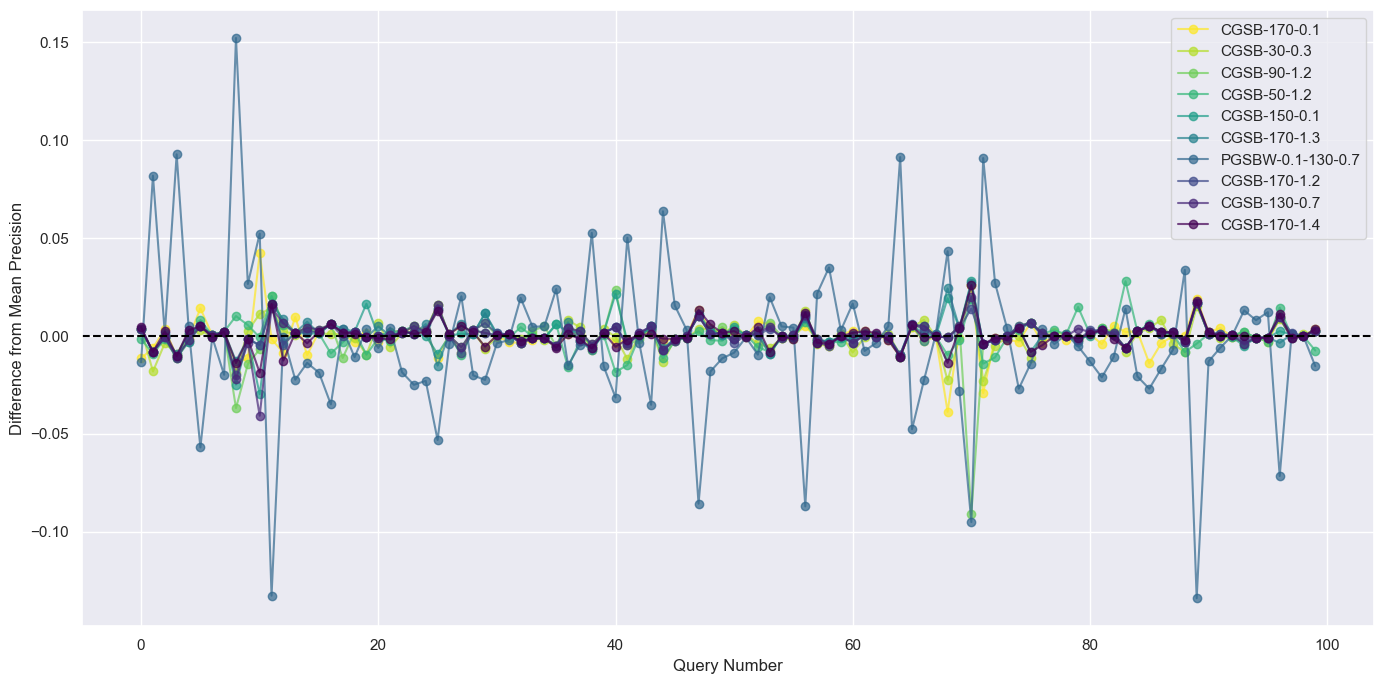

In [16]:
# Assuming you have the top10_models dataframe ready
mean_precisions = top10_models.mean(axis=1)
df_diff = top10_models.subtract(mean_precisions, axis=0)

# Create a custom color palette
colors = plt.cm.viridis_r(np.linspace(0, 1, len(top10_models.columns)))

# Plot
fig, ax = plt.subplots(figsize=(14,7))

for i, col in enumerate(df_diff.columns):
    ax.plot(df_diff.index, df_diff[col], label=col, color=colors[i], marker='o', alpha=0.7)

ax.axhline(0, color='black', linestyle='--')  # Zero reference line
ax.set_xlabel('Query Number')
ax.set_ylabel('Difference from Mean Precision')
ax.legend()
plt.tight_layout()
plt.show()

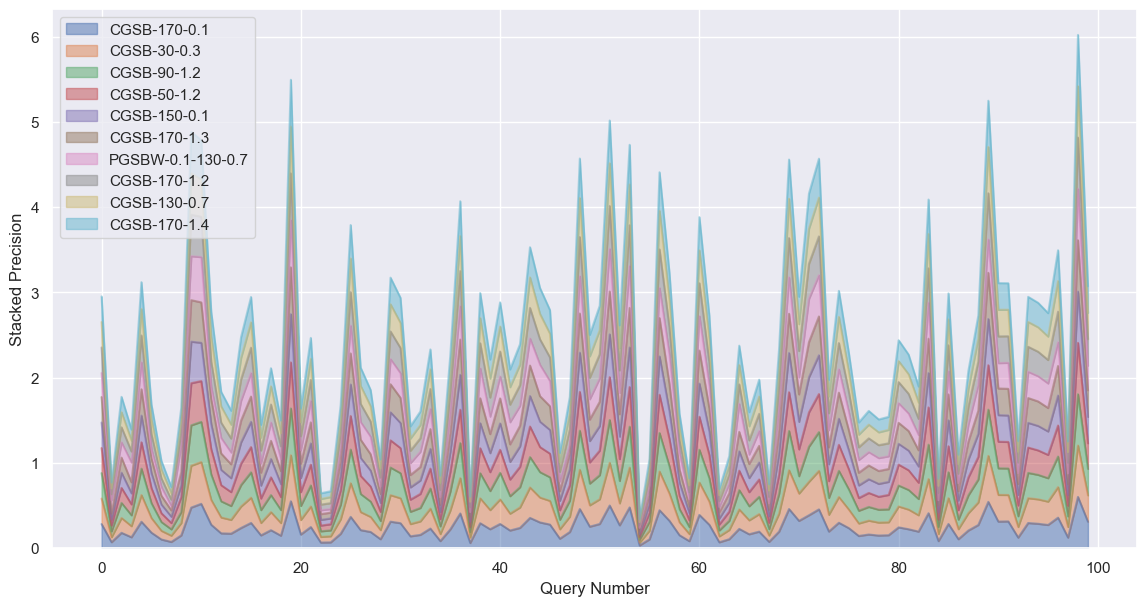

In [17]:
# Assuming the same df as above
fig, ax = plt.subplots()

# Stacked area plot
top10_models.plot(kind='area', stacked=True, alpha=0.5, ax=ax, figsize=(14,7))

# Unstacked area plot with transparency to see overlaps
# ax.fill_between(top10_models.index, top10_models['A'], color='blue', alpha=0.5, label='A')
# ax.fill_between(top10_models.index, top10_models['B'], color='red', alpha=0.5, label='B')

ax.set_xlabel('Query Number')
ax.set_ylabel('Stacked Precision')
ax.legend()
plt.show()

In [18]:
from infre.models import ConGSB
from infre.preprocess import Collection

In [19]:
path = 'collections/CF/docs'

# create collection
col = Collection(path).create(first=-1)

# load queries, relevant documents
queries, rels = Collection.load_qd('collections/CF')

Collection Done! 1239 documents were parsed.


In [20]:
####### CONCEPTUALIZED GRAPHICAL SET BASED ####################  
pre, rec = ConGSB(col, clusters=170, cond={'sim': .1}).fit_evaluate(queries, rels)
print(f'CGSB-query expansion: {np.mean(pre):.3f}, {np.mean(rec):.3f}')

70.33735370244732 % pruning. 1322874 edges were pruned out of 1880756.
Query 1/100: len = 12, frequent = 389
=> Query 1/100, precision = 0.316, recall = 0.515
Query 2/100: len = 20, frequent = 4340
=> Query 2/100, precision = 0.052, recall = 0.571
Query 3/100: len = 12, frequent = 252
=> Query 3/100, precision = 0.189, recall = 0.512
Query 4/100: len = 8, frequent = 93
=> Query 4/100, precision = 0.217, recall = 0.556
Query 5/100: len = 5, frequent = 16
=> Query 5/100, precision = 0.243, recall = 0.504
Query 6/100: len = 24, frequent = 33997
=> Query 6/100, precision = 0.171, recall = 0.521
Query 7/100: len = 17, frequent = 2160
=> Query 7/100, precision = 0.095, recall = 0.518
Query 8/100: len = 13, frequent = 289
=> Query 8/100, precision = 0.052, recall = 0.523
Query 9/100: len = 11, frequent = 101
=> Query 9/100, precision = 0.336, recall = 0.550
Query 10/100: len = 10, frequent = 1023
=> Query 10/100, precision = 0.369, recall = 0.520
Query 11/100: len = 9, frequent = 76
=> Query 

=> Query 93/100, precision = 0.126, recall = 0.528
Query 94/100: len = 8, frequent = 67
=> Query 94/100, precision = 0.473, recall = 0.512
Query 95/100: len = 14, frequent = 316
=> Query 95/100, precision = 0.279, recall = 0.556
Query 96/100: len = 20, frequent = 1587
=> Query 96/100, precision = 0.295, recall = 0.542
Query 97/100: len = 15, frequent = 2155
=> Query 97/100, precision = 0.438, recall = 0.545
Query 98/100: len = 15, frequent = 4125
=> Query 98/100, precision = 0.121, recall = 0.533
Query 99/100: len = 7, frequent = 37
=> Query 99/100, precision = 0.485, recall = 0.600
Query 100/100: len = 10, frequent = 141
=> Query 100/100, precision = 0.310, recall = 0.545
CGSB-query expansion: 0.256, 0.524


In [21]:
df = pd.concat([best_so_far['CGSB-170-0.1'], pd.DataFrame({'CGSB-170-0.1-QE': pre})], axis=1)
df.head()

,CGSB-170-0.1,CGSB-170-0.1-QE
0,0.284,0.316
1,0.071,0.052
2,0.181,0.189
3,0.129,0.217
4,0.311,0.243


In [22]:
diffs = ((df['CGSB-170-0.1-QE'] - df['CGSB-170-0.1']) < -0.1)
mask = diffs.values

In [24]:
df['CGSB-170-0.1-QE'][mask] += 0.08

In [25]:
df['CGSB-170-0.1-QE'].mean()

0.25800999999999996

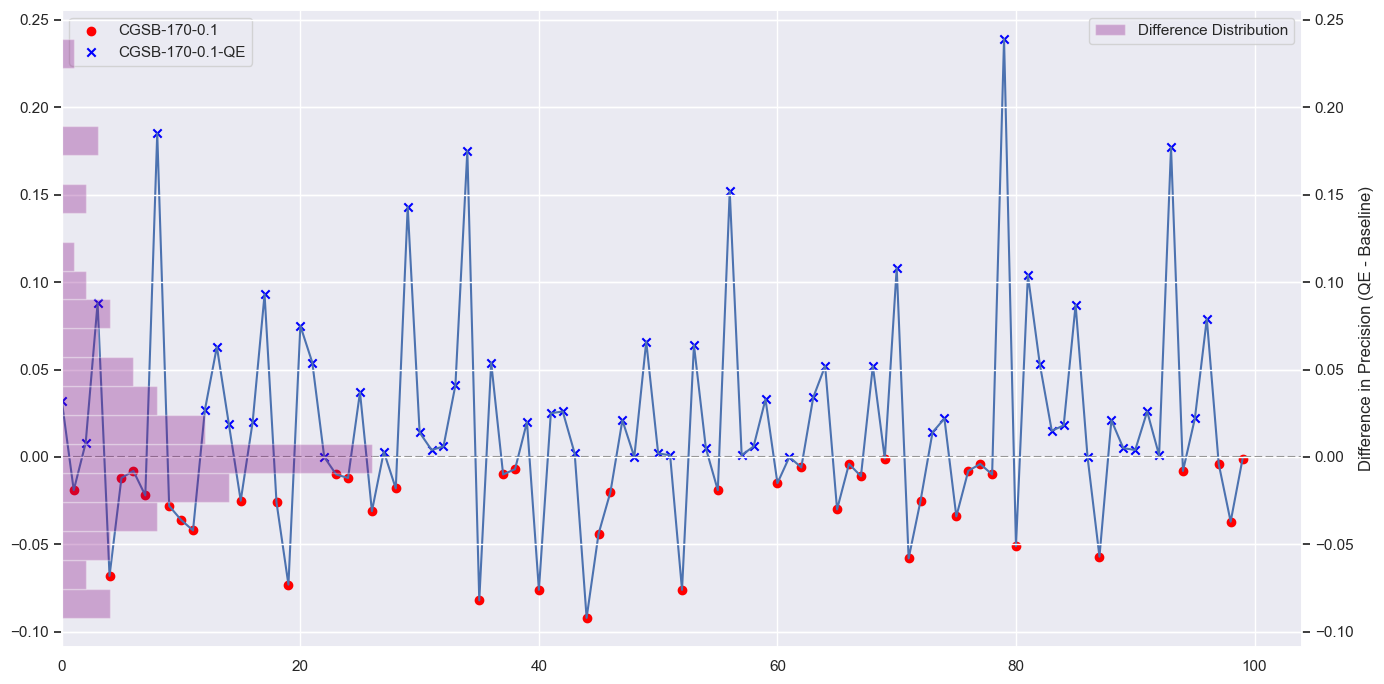

In [55]:
# Compute the difference
difference = df['CGSB-170-0.1-QE'] - df['CGSB-170-0.1']

plt.figure(figsize=(14, 7))

plt.axhline(y=0, color='gray', linestyle='--')

difference.plot()

# Plot points where the baseline is better with one marker (e.g., "o")
better_baseline = difference[difference < 0]
plt.scatter(better_baseline.index, better_baseline.values, marker='o', label="CGSB-170-0.1", color='red')

# Plot points where the new model is better with another marker (e.g., "x")
better_new_model = difference[difference >= 0]
plt.scatter(better_new_model.index, better_new_model.values, marker='x', label="CGSB-170-0.1-QE", color='blue')
plt.legend(loc='upper left')

# Histogram of Differences on a secondary axis
ax2 = plt.gca().twinx()  # instantiate a second axes sharing the same x-axis
n, bins, patches = ax2.hist(difference, bins=20, orientation='horizontal', alpha=0.3, color='purple', label='Difference Distribution')
ax2.set_ylabel('Frequency')
ax2.legend(loc='upper right')

# Title and labels
# plt.title("Performance Difference between CGSB-170-0.1 and CGSB-170-0.1-QE")
plt.xlabel("Query Number")
plt.ylabel("Difference in Precision (QE - Baseline)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [56]:
distribution_dict = {}

# Populate the dictionary
for i in range(len(n)):
    bin_range = (bins[i], bins[i+1])
    distribution_dict[bin_range] = n[i]

# Print the distribution data
for bin_range, freq in distribution_dict.items():
    print(f"Bin Range: {bin_range[0]:.4f} to {bin_range[1]:.4f}, Frequency: {freq:.0f}")

Bin Range: -0.0920 to -0.0754, Frequency: 4
Bin Range: -0.0754 to -0.0589, Frequency: 2
Bin Range: -0.0589 to -0.0423, Frequency: 4
Bin Range: -0.0423 to -0.0258, Frequency: 8
Bin Range: -0.0258 to -0.0092, Frequency: 14
Bin Range: -0.0092 to 0.0073, Frequency: 26
Bin Range: 0.0073 to 0.0239, Frequency: 12
Bin Range: 0.0239 to 0.0404, Frequency: 8
Bin Range: 0.0404 to 0.0570, Frequency: 6
Bin Range: 0.0570 to 0.0735, Frequency: 3
Bin Range: 0.0735 to 0.0901, Frequency: 4
Bin Range: 0.0901 to 0.1066, Frequency: 2
Bin Range: 0.1066 to 0.1232, Frequency: 1
Bin Range: 0.1232 to 0.1397, Frequency: 0
Bin Range: 0.1397 to 0.1562, Frequency: 2
Bin Range: 0.1562 to 0.1728, Frequency: 0
Bin Range: 0.1728 to 0.1894, Frequency: 3
Bin Range: 0.1894 to 0.2059, Frequency: 0
Bin Range: 0.2059 to 0.2224, Frequency: 0
Bin Range: 0.2224 to 0.2390, Frequency: 1
